In [1]:
%matplotlib inline

import glob
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as ml
import numpy
import pandas
import random
import seaborn

matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['savefig.dpi'] = 300
seaborn.set_context({"figure.figsize": (12, 8)})

In [2]:
def calc_rho(species, basedir='data'):
    """
    Calculate \rho, the proportion of iiLocus length to giLocus length, for a particular genome.
    """
    files = ['{}/{}/{}.iloci.tsv'.format(basedir, s, s) for s in species]
    data = pandas.concat([pandas.read_csv(f,sep='\t') for f in files])
    giloci = data.loc[data.LocusClass.isin(['siLocus', 'ciLocus', 'niLocus'])]
    iiloci = data.loc[data.LocusClass.isin(['iiLocus'])]
    quant = list(giloci['Length'].quantile([0.05, 0.95]))
    giloci_q = giloci.loc[(giloci.Length >= quant[0]) & (giloci.Length <= quant[1])]
    quant = list(iiloci['Length'].quantile([0.05, 0.95]))
    iiloci_q = iiloci.loc[(iiloci.Length >= quant[0]) & (iiloci.Length <= quant[1])]
    rho = iiloci_q['Length'].mean() / giloci_q['Length'].mean()
    return rho

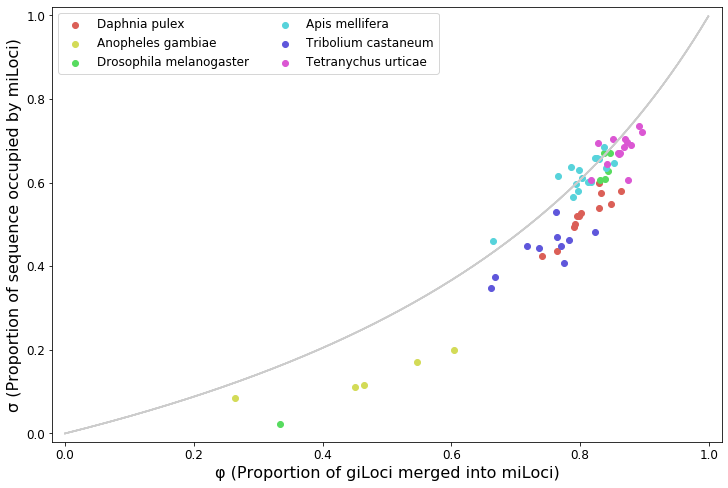

In [3]:
speciesnames = ['Daphnia pulex', 'Anopheles gambiae', 'Drosophila melanogaster',
                'Apis mellifera', 'Tribolium castaneum', 'Tetranychus urticae', ]
specieslist = ['Dpul', 'Agam', 'Dmel', 'Amel', 'Tcas', 'Turt']
palette = seaborn.color_palette("hls", len(specieslist))
rho = calc_rho(specieslist, basedir='data')

data = pandas.read_csv('tables/phisigma-Dpul.tsv',sep='\t')
plots = list()
for i, species in enumerate(specieslist):
    specdata = data.loc[(data.Species == species)]
    plot = plt.scatter(specdata['Phi'], specdata['Sigma'], color=palette[i])
    plots.append(plot)
    x = [k / 1000 for k in range(1000)]
    y = [(k/(1+(1-k)*rho)) for k in x]
    _ = plt.plot(x, y, color='#cccccc')
_ = plt.xlim(-0.02, 1.02)
_ = plt.ylim(-0.02, 1.02)
_ = plt.xlabel('φ (Proportion of giLoci merged into miLoci)')
_ = plt.ylabel('σ (Proportion of sequence occupied by miLoci)')
_ = plt.legend(plots, speciesnames, scatterpoints=1,
           loc='upper left',
           ncol=2,
           fontsize=12)
plt.savefig('figures/LSB20GB-SuppFig4c.png')

In [4]:
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [5]:
def draw_hist(data, series, species, numbins=25, mybins=None,
              xlabel=None, xlim=None, xticks=None, xticklabs=None,
              ylabel=None, ylim=None, yticks=None, yticklabs=None,
              palette=None):
    
    alldata = list()
    for spec in species:
        subdata = data.loc[data.Species == spec]
        alldata.append(subdata[series])

    if not mybins:
        mybins = numbins
        if xlim:
            mybins = numpy.linspace(xlim[0], xlim[1], numbins)

    fig, ax = plt.subplots()
    plot = ax.hist(alldata, bins=mybins, color=palette, label=species)

    if xlabel is not None:
        _ = ax.set_xlabel(xlabel)
    if xticks is not None:
        _ = ax.set_xticks(xticks)
    if xticklabs is not None:
        _ = ax.set_xticklabels(xticklabs)
    if ylabel is not None:
        _ = ax.set_ylabel(ylabel)
    if yticks is not None:
        _ = ax.set_yticks(yticks)
    if yticklabs is not None:
        _ = ax.set_yticklabels(yticklabs)
    if xlim:
        _ = ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        _ = ax.set_ylim(ylim[0], ylim[1])
    _ = ax.legend(loc='upper right', ncol=1, fontsize=12)
    
    # Cleanup
    seaborn.despine(left=True)
    _ = matplotlib.pyplot.title("")
    _ = matplotlib.pyplot.suptitle("")

In [6]:
def load_data(pattern, loglength=True):
    filelist = glob.glob(pattern)
    data = pandas.concat([pandas.read_csv(f,sep='\t') for f in filelist])
    data['Length'] = data['Length'].astype(int)
    if loglength:
        data['LogLength'] = numpy.log10(data['Length'])
    return data

In [7]:
def silocus_mrnas(pattern, silocus_ids):
    filelist = glob.glob(pattern)
    data = pandas.concat([pandas.read_csv(f, sep='\t', header=None, names=('iLocusID', 'MrnaAccession')) for f in filelist])
    subdata = data.loc[data.iLocusID.isin(silocus_ids)]
    return list(subdata['MrnaAccession'])

In [8]:
iloci = load_data('data/*/*.iloci.tsv')
iiloci = iloci[iloci['LocusClass'] == 'iiLocus']

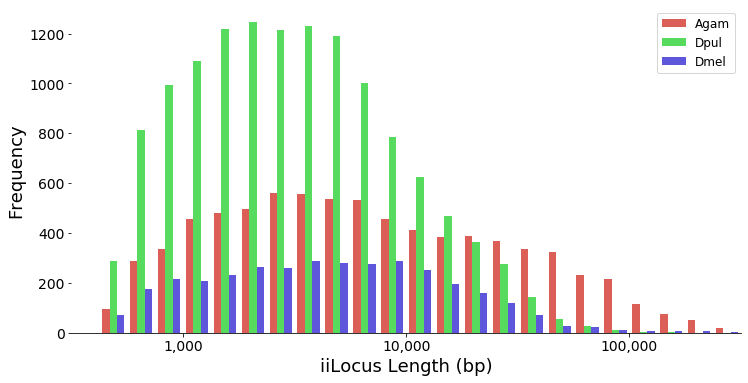

In [9]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(iiloci, 'LogLength', species=specieslist, ylabel='Frequency',
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='iiLocus Length (bp)', xlim=(2.5, 5.5),
          xticks=(3,4,5), xticklabs=('1,000', '10,000', '100,000'))
plt.savefig('figures/LSB20GB-SuppFig7-ii-lengths.png')

In [10]:
siloci = iloci[iloci['LocusClass'] == 'siLocus']

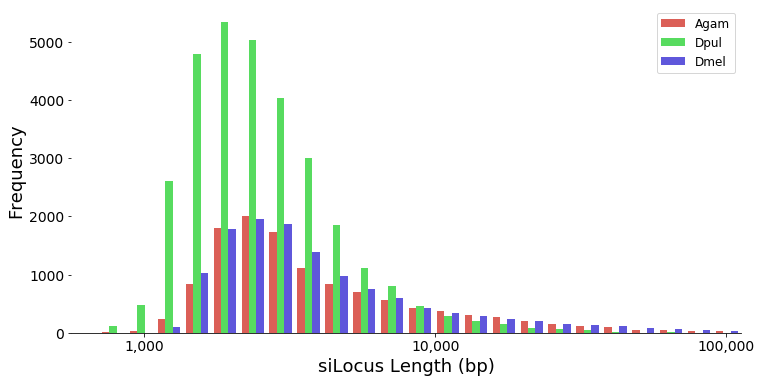

In [11]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(siloci, 'LogLength', species=specieslist, ylabel='Frequency',
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='siLocus Length (bp)', xlim=(2.75, 5.05),
          xticks=(3,4,5), xticklabs=('1,000', '10,000', '100,000'))
plt.savefig('figures/LSB20GB-SuppFig7-si-lengths.png')

In [12]:
premrnas = load_data('data/*/*.pre-mrnas.tsv')
silocus_ids = siloci['LocusId']
silocus_mrna_ids = silocus_mrnas('data/*/*.ilocus.mrnas.tsv', silocus_ids)
silocus_premrnas = premrnas.loc[premrnas.Accession.isin(silocus_mrna_ids)].copy()
silocus_premrnas['ExonCountMax'] = [min(x, 20) for x in silocus_premrnas['ExonCount']]

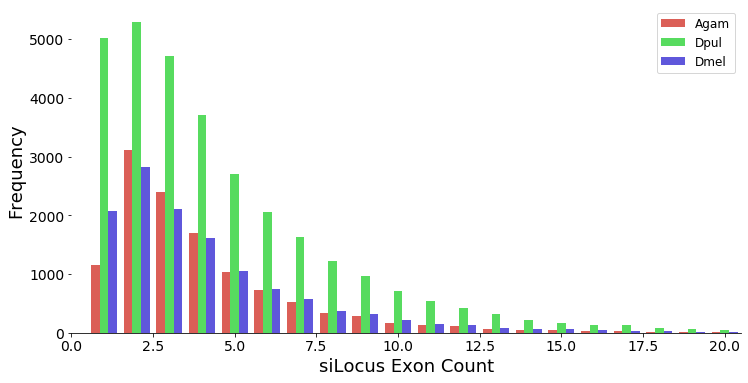

In [13]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(silocus_premrnas, 'ExonCount', species=specieslist, ylabel='Frequency',
          palette=seaborn.color_palette("hls", len(specieslist)),
          mybins=[x - 0.5 for x in range(1, 22)], xlabel='siLocus Exon Count', xlim=(0, 20.5))
plt.savefig('figures/LSB20GB-SuppFig7-si-exon-numbers.png')

In [14]:
introns = load_data('data/*/*.introns.tsv', loglength=True)
introns = introns.loc[introns.MrnaAcc.isin(silocus_mrna_ids)]
introns.head()

,Species,IntronPos,MrnaAcc,Length,GCContent,GCSkew,NContent,Context,LogLength
0,Dmel,NC_004353.4_1080-1143+,gnl|FlyBase|CG45760-RB,64,0.047,1.000,0.0,cds,1.806180
1,Dmel,NC_004353.4_1411-1767+,gnl|FlyBase|CG45760-RB,357,0.266,0.011,0.0,cds,2.552668
2,Dmel,NC_004353.4_3852-4352+,gnl|FlyBase|CG45760-RB,501,0.299,-0.067,0.0,cds,2.699838
3,Dmel,NC_004353.4_4528-4591+,gnl|FlyBase|CG45760-RB,64,0.312,0.200,0.0,cds,1.806180
4,Dmel,NC_004353.4_4825-4874+,gnl|FlyBase|CG45760-RB,50,0.260,0.077,0.0,cds,1.698970


In [15]:
introns.groupby(['Species']).median()

,Length,GCContent,GCSkew,NContent,LogLength
Species,,,,,
Acen,358,0.3830,0.011,0.0,2.553883
Aech,236,0.2510,0.021,0.0,2.372912
Agam,91,0.4320,0.000,0.0,1.959041
Amel,123,0.1670,0.057,0.0,2.089905
Apro,185,0.6170,-0.010,0.0,2.267172
Atha,100,0.3270,0.034,0.0,2.000000
Bdis,144,0.3680,-0.003,0.0,2.158362
Bter,125,0.2580,0.021,0.0,2.096910
Cele,64,0.2870,0.030,0.0,1.806180


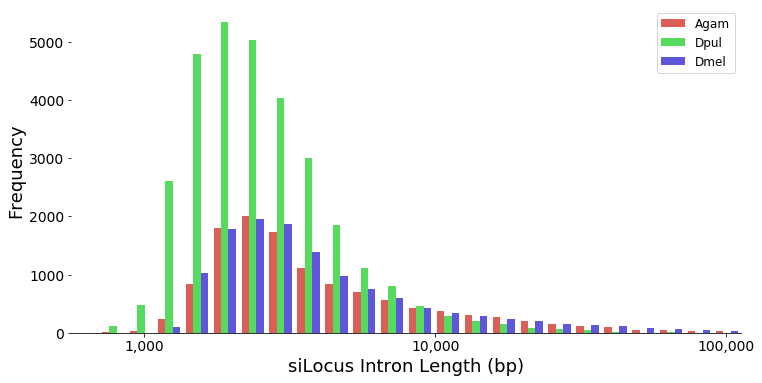

In [16]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(siloci, 'LogLength', species=specieslist, ylabel='Frequency',
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='siLocus Intron Length (bp)', xlim=(2.75, 5.05),
          xticks=(3,4,5), xticklabs=('1,000', '10,000', '100,000'))
plt.savefig('figures/LSB20GB-SuppFig7-si-intron-lengths.png')

In [17]:
exons = load_data('data/*/*.exons.tsv', loglength=True)
exons = exons.loc[exons.MrnaAcc.isin(silocus_mrna_ids)]
exons.head()

,Species,ExonPos,MrnaAcc,Length,GCContent,GCSkew,NContent,Context,Phase,Remainder,LogLength
0,Dmel,NC_004353.4_879-1079+,gnl|FlyBase|CG45760-RB,201,0.289,0.034,0.0,start,None,None,2.303196
1,Dmel,NC_004353.4_1144-1410+,gnl|FlyBase|CG45760-RB,267,0.393,-0.067,0.0,cds,0,0,2.426511
2,Dmel,NC_004353.4_1768-3851+,gnl|FlyBase|CG45760-RB,2084,0.393,0.065,0.0,cds,0,2,3.318898
3,Dmel,NC_004353.4_4353-4527+,gnl|FlyBase|CG45760-RB,175,0.377,0.121,0.0,cds,1,0,2.243038
4,Dmel,NC_004353.4_4592-4824+,gnl|FlyBase|CG45760-RB,233,0.365,0.012,0.0,cds,0,2,2.367356


In [18]:
exons.groupby(['Species']).median()

,Length,GCContent,GCSkew,NContent,LogLength
Species,,,,,
Acen,135.0,0.500,0.0310,0.0,2.130334
Aech,207.0,0.409,0.0650,0.0,2.315970
Agam,241.0,0.539,0.0290,0.0,2.382017
Amel,209.0,0.352,0.0870,0.0,2.320146
Apro,147.0,0.655,0.0110,0.0,2.167317
Atha,162.0,0.422,0.0770,0.0,2.209515
Bdis,165.0,0.467,0.0570,0.0,2.217484
Bter,212.0,0.389,0.0720,0.0,2.326336
Cele,164.0,0.411,0.0130,0.0,2.214844


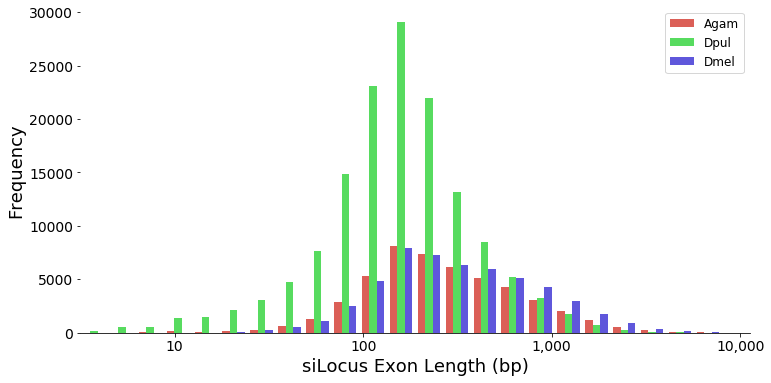

In [19]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(exons, 'LogLength', species=specieslist, ylabel='Frequency',
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='siLocus Exon Length (bp)', xlim=(0.5, 4.05),
          xticks=(1,2,3,4), xticklabs=('10', '100', '1,000', '10,000'))
plt.savefig('figures/LSB20GB-SuppFig7-si-exon-lengths.png')